In [3]:
%load_ext zipline
%load_ext watermark
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

from collections import OrderedDict
import pytz

# необходимые функции zipline
from zipline.api import (order, record, symbol, set_benchmark, order_target_percent, get_open_orders, order_target, 
                        schedule_function, date_rules, time_rules, order_percent, symbols)
# комиссии
from zipline.finance import commission
from zipline.finance import slippage
from zipline.finance.slippage import SlippageModel

# выбор календаря по которому происходит торговля
from trading_calendars.always_open import AlwaysOpenCalendar

import zipline

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime, date

# aинансовые данные
from yahoofinancials import YahooFinancials

# отчёт
import pyfolio as pf

# import helper functions 
import qf_helper_functions as qf

import pypfopt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

import pylab

from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import style
from matplotlib import mlab
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.ticker as mtick
%matplotlib inline

plt.style.use('default')
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 200

#векторный формат
%config InlineBackend.figure_format = 'svg'

from tqdm import tqdm

from __future__ import division
import numpy as np
from matplotlib import pyplot as plt
from numpy.linalg import inv,pinv
from scipy.optimize import minimize

In [5]:
# risk budgeting optimization
def calculate_portfolio_var(w,V):
    # function that calculates portfolio risk
    w = np.matrix(w)
    return (w*V*w.T)[0,0]

def calculate_risk_contribution(w,V):
    # function that calculates asset contribution to total risk
    w = np.matrix(w)
    sigma = np.sqrt(calculate_portfolio_var(w,V))
    # Marginal Risk Contribution
    MRC = V*w.T
    # Risk Contribution
    RC = np.multiply(MRC,w.T)/sigma
    return RC

def risk_budget_objective(x,pars):
    # calculate portfolio risk
    V = pars[0]# covariance table
    x_t = pars[1] # risk target in percent of portfolio risk
    sig_p =  np.sqrt(calculate_portfolio_var(x,V)) # portfolio sigma
    risk_target = np.asmatrix(np.multiply(sig_p,x_t))
    asset_RC = calculate_risk_contribution(x,V)
    J = sum(np.square(asset_RC-risk_target.T))[0,0] # sum of squared error
    return J

def total_weight_constraint(x):
    return np.sum(x)-1.0

def long_only_constraint(x):
    return x

# Прогружаем данные

In [6]:
def download_csv_data(ticker, start_date, end_date, freq, path):
    
    yahoo_financials = YahooFinancials(ticker)

    df = yahoo_financials.get_historical_price_data(start_date, end_date, freq)
    df = pd.DataFrame(df[ticker]['prices']).drop(['date'], axis=1) \
            .rename(columns={'formatted_date':'date'}) \
            .loc[:, ['date','open','high','low','close', 'adjclose', 'volume']] \
            .set_index('date')
    df.index = pd.to_datetime(df.index)
    df['dividend'] = 0
    df['split'] = 1

    # save data to csv for later ingestion
    df.to_csv(path, header=True, index=True)

    # plot the time series
    
    fig, ax = plt.subplots(figsize=[14, 4])
    
    # portfolio value
    df.close.plot(color='g')
    ax.set_xlabel('')
    #ax.tick_params(axais = 'x', direction = 'out')

    #plt.legend()
    #plt.yscale('log')
    plt.title('Ethereum', fontsize = 10)
    #plt.xticks(rotation='horizontal')
    plt.show()
    
    fig.savefig('Ethereum_price.png', transparent=False, dpi=500, bbox_inches="tight")

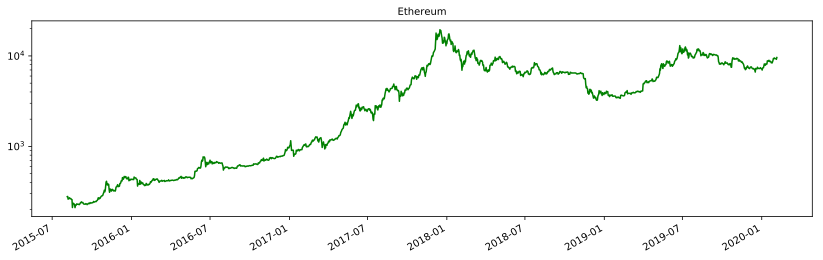

In [168]:
download_csv_data(ticker='BTC-USD', 
                  start_date='2015-08-06', 
                  end_date='2020-02-05', 
                  freq='daily', 
                  path='data/BTC.csv')

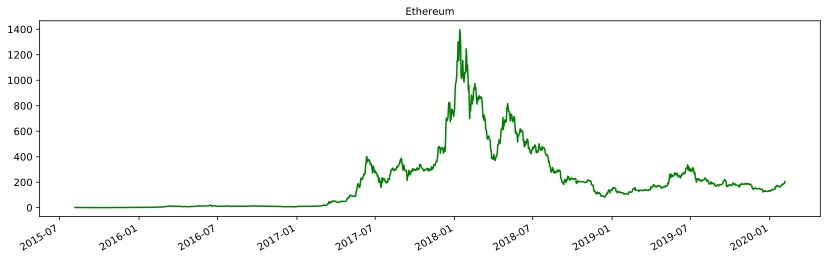

In [7]:
download_csv_data(ticker='ETH-USD', 
                  start_date='2015-08-06', 
                  end_date='2020-02-05', 
                  freq='daily', 
                  path='data/ETH.csv')

In [170]:
# Список финансовых инструментов в портфеле
TIKERS = ['BTC', 'ETH']

# Данные которые будут использоваться в дальнейшем
COLUMNS = ['open', 'close', 'adjclose']

In [171]:
data = OrderedDict()

for tiker in TIKERS:
    data[tiker] = pd.read_csv("data/{}.csv".format(tiker), index_col=0, parse_dates=['date'])
    data[tiker] = data[tiker][COLUMNS]
    data[tiker] = data[tiker].resample("1d").mean()
    data[tiker].fillna(method="ffill", inplace=True)
    data[tiker]['close'] = data[tiker]['adjclose']
    data[tiker]['open'] = data[tiker]['adjclose']
    del data[tiker]['adjclose']
    print(data[tiker].head())
COLUMNS = ['open', 'close']

                  open       close
date                              
2015-08-05  278.576996  278.576996
2015-08-06  279.584991  279.584991
2015-08-07  260.997009  260.997009
2015-08-08  265.083008  265.083008
2015-08-09  264.470001  264.470001
                open     close
date                          
2015-08-06  2.772120  2.772120
2015-08-07  0.753325  0.753325
2015-08-08  0.701897  0.701897
2015-08-09  0.708448  0.708448
2015-08-10  1.067860  1.067860


In [172]:
panel = pd.Panel(data)
panel.minor_axis = COLUMNS
panel.major_axis = panel.major_axis.tz_localize(pytz.utc)
print(panel)

<class 'pandas.core.panel.Panel'>
Dimensions: 2 (items) x 1646 (major_axis) x 2 (minor_axis)
Items axis: BTC to ETH
Major_axis axis: 2015-08-05 00:00:00+00:00 to 2020-02-05 00:00:00+00:00
Minor_axis axis: open to close


# Взаимная корреляция

In [173]:
data_corr = data['BTC']
for tiker in TIKERS:
    data_corr[tiker] = data[tiker]['close']
del data_corr['open']
del data_corr['close']
data_corr.corr()

,BTC,ETH
BTC,1.000000,0.764315
ETH,0.764315,1.000000


# Risk

### Определяем стартовые переменные

In [174]:
# Custom slippage model
class InstantSlippage(SlippageModel):
    
    def process_order(self, data, order):
        # Use price from previous bar
        price = data.history(order.sid, 'price', 2, '1d')[0]
        
        # Alternative: Use current bar's open, instead of close
        # price = data.current(order.sid, 'open')

        return (price, order.amount)

In [175]:
num_assets = len(TIKERS)
performance_list = []
COMMISSION = 0.0007
WEIGHTS = [1]


# empty lists to store returns, volatility and weights of imiginary portfolios
port_returns = []
port_volatility = []
stock_weights = []
sharpe_ratio = []

In [176]:
def initialize(context):
    
    context.set_commission(commission.PerDollar(cost=COMMISSION))
    context.set_slippage(InstantSlippage())

    #set_benchmark(symbol('BTC'))

    context.tikers = ['BTC']
    context.assets = [context.symbol(symbol) for symbol in context.tikers]

    context.weights = WEIGHTS
    context.n_assets = len(context.assets)

    context.window = 1

    context.time = 0
        
    
def handle_data(context, data):
    
    if context.time == 0:

        # extract prices
        prices = data.history(context.assets, fields='price', bar_count=context.window, frequency='1d')

        # submit orders
        for i, asset in enumerate(context.assets):
            order_target_percent(asset, context.weights[i])

        context.time += 1
    
perf = zipline.run_algorithm(start=datetime(2015, 8, 6, 0, 0, 0, 0, pytz.utc),
                                end=datetime(2020, 2, 5, 0, 0, 0, 0, pytz.utc),
                                initialize=initialize,
                                capital_base=100000000,
                                handle_data=handle_data,
                                data=panel)

performance_list.append(perf)    
        
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    
sharpe_ratio.append(qf.get_performance_summary(returns).sharpe_ratio)
port_returns.append(qf.get_performance_summary(returns).annualized_returns * 100)
port_volatility.append(qf.get_performance_summary(returns).annual_volatility * 100)
stock_weights.append(WEIGHTS)

Bitcoin = perf.algorithm_period_return

Bitcoin = 100 * (1 + Bitcoin)

Bitcoin = Bitcoin.rename('Bitcoin')

In [177]:
def initialize(context):
    
    context.set_commission(commission.PerDollar(cost=COMMISSION))
    context.set_slippage(InstantSlippage())

    #set_benchmark(symbol('BTC'))

    context.tikers = ['ETH']
    context.assets = [context.symbol(symbol) for symbol in context.tikers]

    context.weights = [1]
    context.n_assets = len(context.assets)

    context.window = 1

    context.time = 0
        
    
def handle_data(context, data):
    
    if context.time == 0:

        # extract prices
        prices = data.history(context.assets, fields='price', bar_count=context.window, frequency='1d')

        # submit orders
        for i, asset in enumerate(context.assets):
            order_target_percent(asset, context.weights[i])

        context.time += 1
    
perf = zipline.run_algorithm(start=datetime(2015, 8, 6, 0, 0, 0, 0, pytz.utc),
                                end=datetime(2020, 2, 5, 0, 0, 0, 0, pytz.utc),
                                initialize=initialize,
                                capital_base=100000000,
                                handle_data=handle_data,
                                data=panel)

performance_list.append(perf)    
        
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    
sharpe_ratio.append(qf.get_performance_summary(returns).sharpe_ratio)
port_returns.append(qf.get_performance_summary(returns).annualized_returns * 100)
port_volatility.append(qf.get_performance_summary(returns).annual_volatility * 100)
stock_weights.append(WEIGHTS)

# Визуализация результатов

In [178]:
# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility,
             'Sharpe Ratio': sharpe_ratio}
    
# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)

# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility', 'Sharpe Ratio']

# reorder dataframe columns
df = df[column_order]

In [179]:
df.head(7)

,Returns,Volatility,Sharpe Ratio
0,119.488641,72.908032,1.443257
1,159.989900,134.665333,1.398217


In [180]:
asset_list = TIKERS

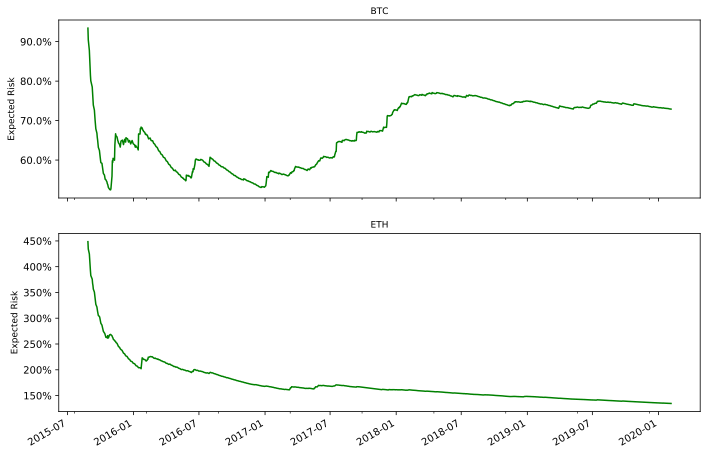

In [181]:
risk_list = []

fig, ax = plt.subplots(len(TIKERS), 1, sharex=True, figsize=[11.5, 8])

for i in range(0, len(TIKERS)):
    risk_list.append(performance_list[i].algo_volatility * 100)
    risk_list[i][15:].plot(ax=ax[i], color='g')
    ax[i].yaxis.set_major_formatter(mtick.PercentFormatter())
    ax[i].set_ylabel('Expected Risk', fontsize = 9)
    ax[i].set_title(asset_list[i], fontsize = 9)

In [182]:
fig.savefig('Risk.png', transparent=False, dpi=500, bbox_inches="tight")

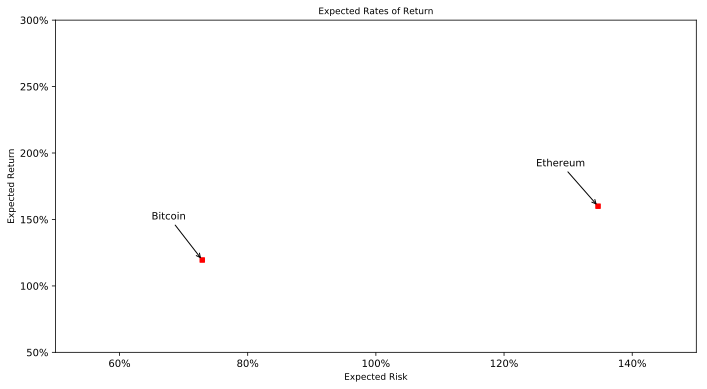

In [183]:
#fig, ax = plt.subplots()
# plot frontier, max sharpe & min Volatility values with a scatterplot
ax = df.plot.scatter(x='Volatility', y='Returns', marker = 's', color='r', edgecolors='r', figsize=(11.5, 6))
plt.xlabel('Expected Risk', fontsize = 9)
plt.ylabel('Expected Return', fontsize = 9)
plt.title('Expected Rates of Return', fontsize = 9)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.set(xlim=(50, 150), ylim=(50, 300))

#https://matplotlib.org/3.1.1/tutorials/text/annotations.html

plt.annotate('Bitcoin', xy=(df.iloc[0]['Volatility'], df.iloc[0]['Returns']), xytext=(65, 150),
             arrowprops=dict(arrowstyle="->"))

plt.annotate('Ethereum', xy=(df.iloc[1]['Volatility'], df.iloc[1]['Returns']), xytext=(125, 190),
             arrowprops=dict(arrowstyle="->"))

plt.show()

fig.savefig('Assets.png', transparent=False, dpi=500, bbox_inches="tight")

In [184]:
Corr = data_corr.corr()
Corr = Corr.as_matrix()

In [185]:
V = Corr.copy()

In [186]:
w0 = df['Volatility']/100
w0 = w0.values.tolist()

In [187]:
for i in range(0, len(Corr)):
    for j in range(0, len(Corr)):
        V[i][j] = Corr[i][j] * w0[i] * w0[j]

In [188]:
TIKERS = ['BTC', 'ETH']

In [189]:
x_t = [0.5, 0.5] # your risk budget percent of total portfolio risk (equal risk)

cons = ({'type': 'eq', 'fun': total_weight_constraint}, {'type': 'ineq', 'fun': long_only_constraint})

res= minimize(risk_budget_objective, w0, args=[V,x_t], method='SLSQP',constraints=cons, options={'disp': True})

w_rb = np.asmatrix(res.x)

w_rb = w_rb.tolist()[0]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.957200406868173e-07
            Iterations: 5
            Function evaluations: 20
            Gradient evaluations: 5


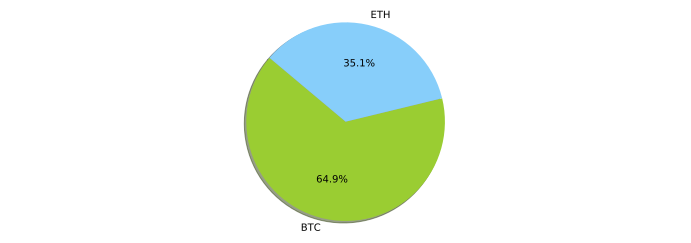

In [190]:
# Data to plot
labels = TIKERS
sizes = w_rb
colors = ['yellowgreen', 'lightskyblue', 'lightcoral', 'gold', 'pink' , 'lightgrey', 'khaki']
explode = (0, 0)  # explode 1st slice

# Plot
weight_pie = plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
#plt.legend(labels, loc="best")
plt.show()

## Визуализация портфеля

In [191]:
WEIGHTS = [0.649, 0.351]
COMMISSION = 0.0007

In [192]:
def initialize(context):
    
    context.set_commission(commission.PerDollar(cost=COMMISSION))
    context.set_slippage(InstantSlippage())

    #set_benchmark(symbol('BTC'))

    context.tikers = TIKERS
    context.assets = [context.symbol(symbol) for symbol in context.tikers]

    context.weights = WEIGHTS
    context.n_assets = len(context.assets)

    context.window = 1

    context.rebalance_period = 84
    context.time = 0

In [193]:
def handle_data(context, data):
    
    # Закупка и ребаллансировка
    if context.time == 0 or (context.time % context.rebalance_period == 0):
        
        
        # submit orders
        for i, asset in enumerate(context.assets):
            order_target_percent(asset, context.weights[i])
            
    
    context.time += 1

In [194]:
perf = zipline.run_algorithm(start=datetime(2015, 8, 6, 0, 0, 0, 0, pytz.utc),
                              end=datetime(2020, 2, 5, 0, 0, 0, 0, pytz.utc),
                              initialize=initialize,
                              capital_base=10000000,
                              handle_data=handle_data,
                              data=panel)

In [195]:
performance_list.append(perf)    
        
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    
sharpe_ratio.append(qf.get_performance_summary(returns).sharpe_ratio)
port_returns.append(qf.get_performance_summary(returns).annualized_returns * 100)
port_volatility.append(qf.get_performance_summary(returns).annual_volatility * 100)
stock_weights.append(WEIGHTS)

In [196]:
# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility,
             'Sharpe Ratio': sharpe_ratio}

# extend original dictionary to accomodate each ticker and weight in the portfolio
#for counter,symbol in enumerate(TIKERS):
    #portfolio[symbol] = [Weight[counter] for Weight in stock_weights]
    
# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)

# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility', 'Sharpe Ratio']

# reorder dataframe columns
df = df[column_order]

In [197]:
df.head(7)

,Returns,Volatility,Sharpe Ratio
0,119.488641,72.908032,1.443257
1,159.989900,134.665333,1.398217
2,217.116585,87.031320,1.758120


In [198]:
asset_list = ['BTC', 'ETH', 'Risk Parity Portfolio']

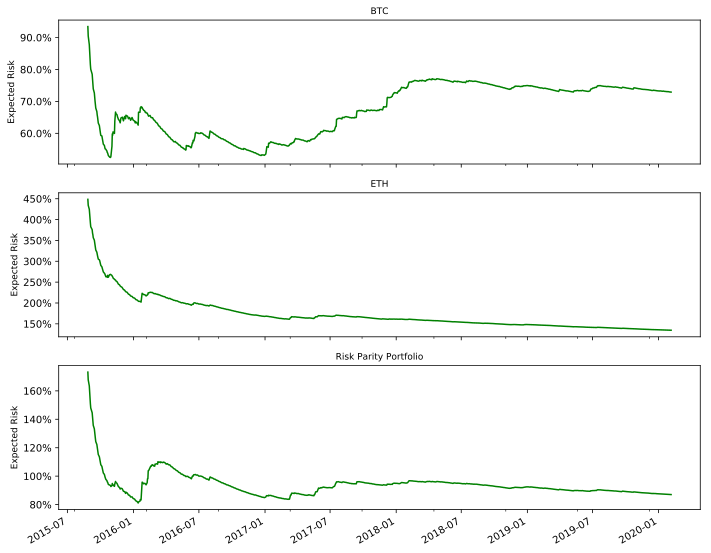

In [199]:
risk_list = []

fig, ax = plt.subplots(len(asset_list), 1, sharex=True, figsize=[11.5, 10])

for i in range(0, len(asset_list)):
    risk_list.append(performance_list[i].algo_volatility * 100)
    risk_list[i][15:].plot(ax=ax[i], color='g')
    ax[i].yaxis.set_major_formatter(mtick.PercentFormatter())
    ax[i].set_ylabel('Expected Risk', fontsize = 9)
    ax[i].set_title(asset_list[i], fontsize = 9)

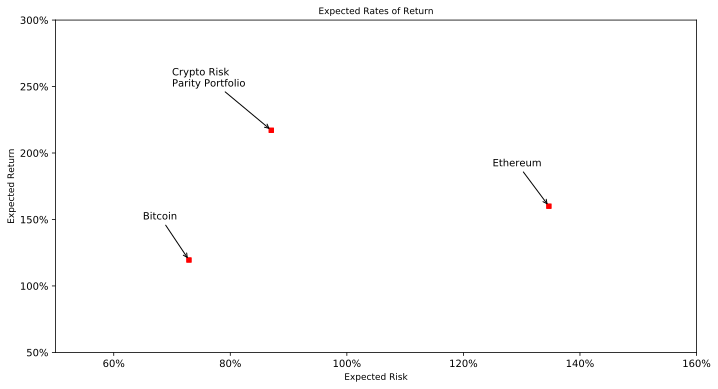

In [200]:
# plot frontier, max sharpe & min Volatility values with a scatterplot
ax = df.plot.scatter(x='Volatility', y='Returns', marker = 's', color='r', edgecolors='r', figsize=(11.5, 6))
plt.xlabel('Expected Risk', fontsize = 9)
plt.ylabel('Expected Return', fontsize = 9)
plt.title('Expected Rates of Return', fontsize = 9)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.set(xlim=(50, 160), ylim=(50, 300))

#https://matplotlib.org/3.1.1/tutorials/text/annotations.html

plt.annotate('Bitcoin', xy=(df.iloc[0]['Volatility'], df.iloc[0]['Returns']), xytext=(65, 150),
             arrowprops=dict(arrowstyle="->"))

plt.annotate('Ethereum', xy=(df.iloc[1]['Volatility'], df.iloc[1]['Returns']), xytext=(125, 190),
             arrowprops=dict(arrowstyle="->"))

plt.annotate('Crypto Risk\nParity Portfolio', xy=(df.iloc[2]['Volatility'], df.iloc[2]['Returns']), xytext=(70, 250),
             arrowprops=dict(arrowstyle="->"))

plt.show()

## RP Portfolio + 16% Cash

In [201]:
WEIGHTS = [0.545, 0.295]
COMMISSION = 0.0007

In [202]:
def initialize(context):
    
    context.set_commission(commission.PerDollar(cost=COMMISSION))
    context.set_slippage(InstantSlippage())

    #set_benchmark(symbol('BTC'))

    context.tikers = TIKERS
    context.assets = [context.symbol(symbol) for symbol in context.tikers]

    context.weights = WEIGHTS
    context.n_assets = len(context.assets)

    context.window = 1

    context.rebalance_period = 63
    context.time = 0

In [203]:
def handle_data(context, data):
    
    # Закупка и ребаллансировка
    if context.time == 0 or (context.time % context.rebalance_period == 0):
        
        
        # submit orders
        for i, asset in enumerate(context.assets):
            order_target_percent(asset, context.weights[i])
            
    
    context.time += 1

In [204]:
perf = zipline.run_algorithm(start=datetime(2015, 8, 6, 0, 0, 0, 0, pytz.utc),
                              end=datetime(2020, 2, 5, 0, 0, 0, 0, pytz.utc),
                              initialize=initialize,
                              capital_base=10000000,
                              handle_data=handle_data,
                              data=panel)

In [205]:
performance_list.append(perf)    
        
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    
sharpe_ratio.append(qf.get_performance_summary(returns).sharpe_ratio)
port_returns.append(qf.get_performance_summary(returns).annualized_returns * 100)
port_volatility.append(qf.get_performance_summary(returns).annual_volatility * 100)
stock_weights.append(WEIGHTS)

In [206]:
RPP_Cash = perf.algorithm_period_return

RPP_Cash = 100 * (1 + RPP_Cash)

RPP_Cash = RPP_Cash.rename('Crypto Risk Parity Portfolio with 16% Cash')

In [207]:
# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility,
             'Sharpe Ratio': sharpe_ratio}

    
# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)

# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility', 'Sharpe Ratio']

# reorder dataframe columns
df = df[column_order]

In [208]:
df.head(7)

,Returns,Volatility,Sharpe Ratio
0,119.488641,72.908032,1.443257
1,159.989900,134.665333,1.398217
2,217.116585,87.031320,1.758120
3,166.326267,72.792757,1.708970


In [209]:
asset_list = ['BTC', 'ETH', 'RP', 'RP + Cash']

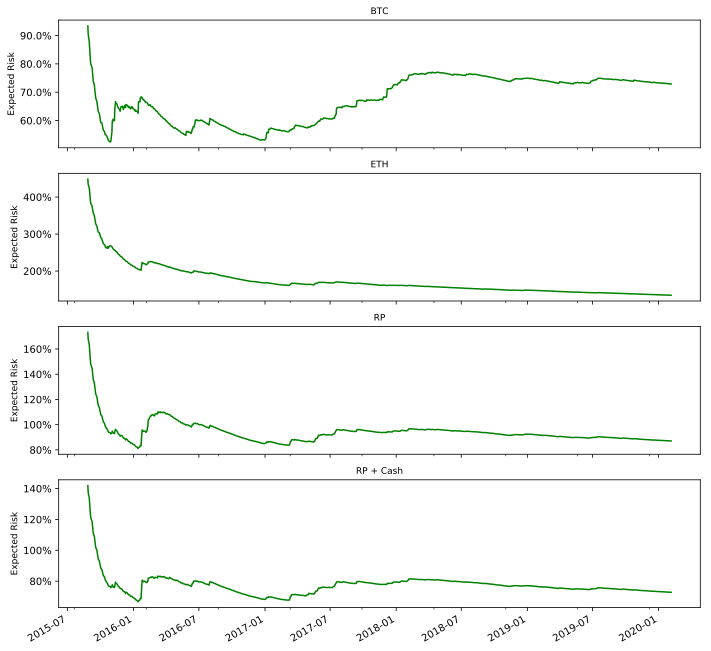

In [210]:
risk_list = []

fig, ax = plt.subplots(len(asset_list), 1, sharex=True, figsize=[11.5, 12])

for i in range(0, len(asset_list)):
    risk_list.append(performance_list[i].algo_volatility * 100)
    risk_list[i][15:].plot(ax=ax[i], color='g')
    ax[i].yaxis.set_major_formatter(mtick.PercentFormatter())
    ax[i].set_ylabel('Expected Risk', fontsize = 9)
    ax[i].set_title(asset_list[i], fontsize = 9)

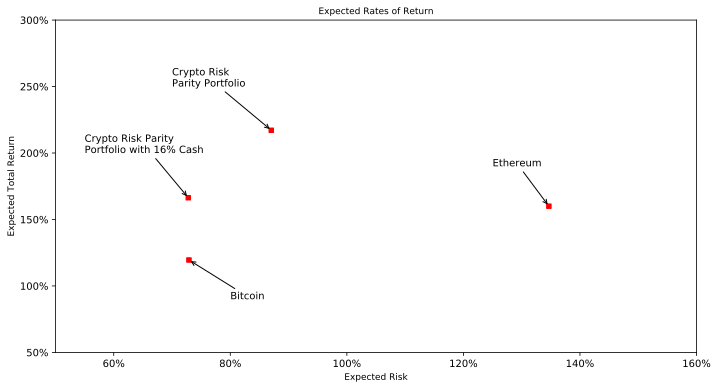

In [211]:
# plot frontier, max sharpe & min Volatility values with a scatterplot
ax = df.plot.scatter(x='Volatility', y='Returns', marker = 's', color='r', edgecolors='r', figsize=(11.5, 6))
plt.xlabel('Expected Risk', fontsize = 9)
plt.ylabel('Expected Total Return', fontsize = 9)
plt.title('Expected Rates of Return', fontsize = 9)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.set(xlim=(50, 160), ylim=(50, 300))

#https://matplotlib.org/3.1.1/tutorials/text/annotations.html

plt.annotate('Bitcoin', xy=(df.iloc[0]['Volatility'], df.iloc[0]['Returns']), xytext=(80, 90),
             arrowprops=dict(arrowstyle="->"))

plt.annotate('Ethereum', xy=(df.iloc[1]['Volatility'], df.iloc[1]['Returns']), xytext=(125, 190),
             arrowprops=dict(arrowstyle="->"))

plt.annotate('Crypto Risk\nParity Portfolio', xy=(df.iloc[2]['Volatility'], df.iloc[2]['Returns']), xytext=(70, 250),
             arrowprops=dict(arrowstyle="->"))

plt.annotate('Crypto Risk Parity\nPortfolio with 16% Cash', xy=(df.iloc[3]['Volatility'], df.iloc[3]['Returns']), xytext=(55, 200),
             arrowprops=dict(arrowstyle="->"))

plt.show()

In [212]:
RPP_Cash = RPP_Cash.rename('Paradigm Strategy Simulation')

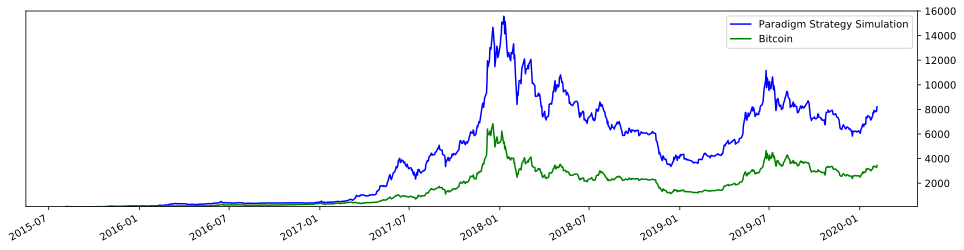

Final portfolio return: 100.0%
Final benchmark return: 100.0%
Final portfolio return: 8210.38%
Final benchmark return: 3438.38%


In [226]:
fig, ax = plt.subplots(figsize=[16, 4])

# portfolio value
RPP_Cash.plot(color='b')
Bitcoin.plot(color='g')

ax.set(ylim=(100, 16000))

#ax.set_ylabel('portfolio value in $')

plt.legend()
#plt.yscale('log')
ax.yaxis.tick_right()
plt.show()

print('Final portfolio return: {}%'.format(np.round(RPP_Cash[0], 2)))
print('Final benchmark return: {}%'.format(np.round(Bitcoin[0], 2)))

print('Final portfolio return: {}%'.format(np.round(RPP_Cash[-1], 2)))
print('Final benchmark return: {}%'.format(np.round(Bitcoin[-1], 2)))

In [227]:
fig.savefig('RPP.png', transparent=False, dpi=500, bbox_inches="tight")

# Cash

In [217]:
WEIGHTS = [0.315, 0.21]
COMMISSION = 0.0007

In [218]:
def initialize(context):
    
    context.set_commission(commission.PerDollar(cost=COMMISSION))

    #set_benchmark(symbol('BTC'))

    context.tikers = TIKERS
    context.assets = [context.symbol(symbol) for symbol in context.tikers]

    context.weights = WEIGHTS
    context.n_assets = len(context.assets)

    context.window = 1

    context.rebalance_period = 63
    context.time = 0

In [219]:
def handle_data(context, data):
    
    # Закупка и ребаллансировка
    if context.time == 0 or (context.time % context.rebalance_period == 0):
        
        
        # submit orders
        for i, asset in enumerate(context.assets):
            order_target_percent(asset, context.weights[i])
            
    
    context.time += 1

In [220]:
perf = zipline.run_algorithm(start=datetime(2015, 8, 6, 0, 0, 0, 0, pytz.utc),
                              end=datetime(2020, 1, 16, 0, 0, 0, 0, pytz.utc),
                              initialize=initialize,
                              capital_base=10000000,
                              handle_data=handle_data,
                              data=panel)

In [221]:
performance_list.append(perf)    
        
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    
sharpe_ratio.append(qf.get_performance_summary(returns).sharpe_ratio)
port_returns.append(qf.get_performance_summary(returns).annualized_returns * 100)
port_volatility.append(qf.get_performance_summary(returns).annual_volatility * 100)
stock_weights.append(WEIGHTS)

In [222]:
RPP = perf.algorithm_period_return

RPP = 1000 * (1 + RPP)

RPP = RPP.rename('Risk Parity Portfolio + 47,5% Cash')

In [223]:
# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility,
             'Sharpe Ratio': sharpe_ratio}

# extend original dictionary to accomodate each ticker and weight in the portfolio
for counter,symbol in enumerate(TIKERS):
    portfolio[symbol] = [Weight[counter] for Weight in stock_weights]
    
# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)

# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [stock for stock in TIKERS]

# reorder dataframe columns
df = df[column_order]

In [224]:
df.head(7)

,Returns,Volatility,Sharpe Ratio,BTC,ETH
0,116.968772,72.430987,1.431917,1.000,0.000
1,151.265010,108.995240,1.370121,1.000,0.000
2,212.736934,84.342571,1.767850,0.600,0.390
3,178.436418,72.603208,1.769110,0.493,0.327
4,113.840141,50.885046,1.746370,0.315,0.210


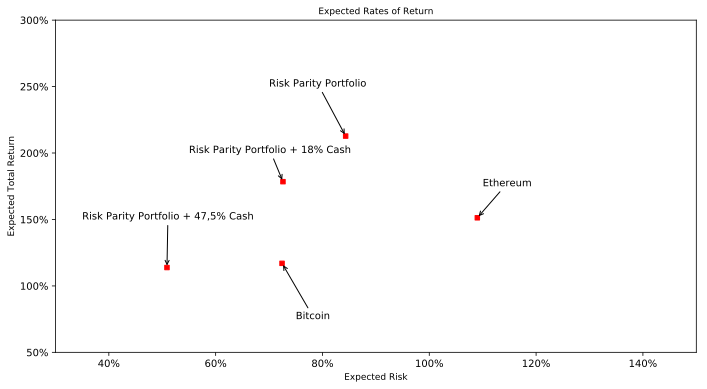

In [242]:
# plot frontier, max sharpe & min Volatility values with a scatterplot
ax = df.plot.scatter(x='Volatility', y='Returns', marker = 's', color='r', edgecolors='r', figsize=(11.5, 6))
plt.xlabel('Expected Risk', fontsize = 9)
plt.ylabel('Expected Total Return', fontsize = 9)
plt.title('Expected Rates of Return', fontsize = 9)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.set(xlim=(30, 150), ylim=(50, 300))

#https://matplotlib.org/3.1.1/tutorials/text/annotations.html

plt.annotate('Bitcoin', xy=(df.iloc[0]['Volatility'], df.iloc[0]['Returns']), xytext=(75, 75),
             arrowprops=dict(arrowstyle="->"))

plt.annotate('Ethereum', xy=(df.iloc[1]['Volatility'], df.iloc[1]['Returns']), xytext=(110, 175),
             arrowprops=dict(arrowstyle="->"))

plt.annotate('Risk Parity Portfolio', xy=(df.iloc[2]['Volatility'], df.iloc[2]['Returns']), xytext=(70, 250),
             arrowprops=dict(arrowstyle="->"))

plt.annotate('Risk Parity Portfolio + 18% Cash', xy=(df.iloc[3]['Volatility'], df.iloc[3]['Returns']), xytext=(55, 200),
             arrowprops=dict(arrowstyle="->"))

plt.annotate('Risk Parity Portfolio + 47,5% Cash', xy=(df.iloc[4]['Volatility'], df.iloc[4]['Returns']), xytext=(35, 150),
             arrowprops=dict(arrowstyle="->"))

plt.show()

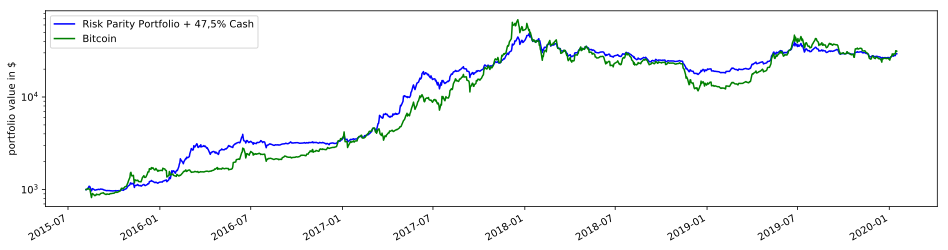

In [240]:
fig, ax = plt.subplots(figsize=[16, 4])

# portfolio value
RPP.plot(color='b')
Bitcoin.plot(color='g')


ax.set_ylabel('portfolio value in $')

plt.legend()
plt.yscale('log')
plt.show()

In [241]:
fig.savefig('RPP_Return.png', transparent=False, dpi=500, bbox_inches="tight")